In [1]:
from tokenize import group

import pandas as pd
import re
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.use('pdf')  # Verwende das pgf Backend

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    # Schriftgrößen – etwas kleiner als 12pt, damit die Figuren nicht „überladen“ wirken:
    "font.size": 10,  # Allgemeine Schriftgröße (z. B. für Achsenbeschriftungen)
    "figure.titlesize": 11,
    "axes.titlesize": 10,  # Titel der Achsen
    "axes.labelsize": 10,  # Achsenbeschriftungen
    "legend.title_fontsize": 9,  # Legenden Schriftgröße
    "legend.fontsize": 9,  # Legenden Schriftgröße
    "xtick.labelsize": 9,  # x-Achsen Tick-Beschriftung
    "ytick.labelsize": 9,  # y-Achsen Tick-Beschriftung
    # Linienbreiten (falls feiner Strich gewünscht ist)
    "lines.linewidth": 1.0,

    "grid.color": 'gray',
    "grid.linestyle": '--',
    "grid.linewidth": 0.5,
    "axes.grid": True,  # Rasterlinien einfügen

    # Figurengröße – bei A4 und ggf. mehrspaltigem Layout sollte man sich an der für die jeweilige Spaltenbreite orientieren;
    # hier als Beispiel eine Breite von ca. 6.0 Zoll (15,2 cm) mit entsprechender Höhe:
    "figure.figsize": (6.5, 6.5 / 1.618),
    # Für gute Druckqualität:
    "savefig.dpi": 300,
    # Um den LaTeX-Praamble anzupassen, etwa um Helvetica (hier: helvet) für Überschriften zu laden,
    # kann man entsprechende Pakete einbinden.
    # \usepackage{helvet}
    #"text.latex.preamble": r"\renewcommand{\familydefault}{\sfdefault}"
    #r"\renewcommand{\familydefault}{\rmdefault}" # Setzt die Standardfamilie auf die LaTeX Standard Serifenschrift
    "pgf.rcfonts": True,  # Verwenden Sie nicht die Standard-Einstellungen von matplotlib
    "pgf.preamble": r"\usepackage[scaled=.95]{helvet}\renewcommand{\familydefault}{\sfdefault}",
    # präambel wie benötigt
})

In [23]:
mpl.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.8',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': True,
          'axes.grid.axis': 'both',


In [17]:
expert_ranking = pd.read_csv('data/shared-dataset-v2/corona_warn_app_analyse_points.csv')
rankings = expert_ranking.loc[:, ['id', 'total_points']]
rankings.rename(columns={'total_points': 'expert'}, inplace=True)

In [18]:
rankings.sort_values(by='expert', ascending=False)

,id,expert
1,3669,20
5,1953,20
6,7cc7,20
16,63e1,20
27,d28c,20
9,fe28,20
13,2281,20
25,eac9,20
19,4c41,20
20,c926,19


## Load Orders from Logfiles

In [19]:
files = {
    '001.2.r1': '001.2_llama3.3_azure.1.log',
    '001.2.r2': '001.2_llama3.3_azure.2.log',
    '001.2.r3': '001.2_llama3.3_azure.3.log',
    '001.2.r4': '001.2_llama3.3_azure.4.log',
    '007.2.r0': '007.2_llama3.3_azure.log'
}

files.update({
    '002.2': '002.2_deepseek_azure.log',
    '004.2': '004.2_azure_corona_warn_app.log',
    '008.2': '008.2_deepseek_azure.log',
    '011.2.r1': '011.2_reorder1.log',
    '011.2.r2': '011.2_reorder2.log',
    '011.2.r3': '011.2_reorder3.log',
    '011.2.r4': '011.2_reorder4.log',
})

files.update({
    '005.2': '005.2_markdown_with_tags.log',
    '006.2': '006.2_majority_vote.log',
    '009.2': '009.2_markdown.log',
    '010.2': '010.2_markdown_with_tags.log',
    '012.2': '012.2_option-labels.log',
    '013.2': '013.2_output_cells.log'
})

for experiment_id, file in files.items():
    with open(f'experiments/logs/{file}', 'r') as f:
        print(f'{file=}')
        for line in f.readlines():
            if re.match(r'.*Final order of notebooks:.*', line):
                print(line)
                matches = re.match(r'.*\[((\'[a-f0-9]+\'(, )?)+)\].*', line).group(1)
                ordering = [re.match(r"'([a-f0-9]+)'", m).group(1) for m in matches.split(', ')]

                rankings[experiment_id] = rankings['id'].map(lambda x: ordering.index(x))

rankings.set_index('id', inplace=True)
rankings

file='001.2_llama3.3_azure.1.log'
2025-02-20 21:47:47,732 [INFO] Sorting finished. Final order of notebooks: ['fb4b', '9eb2', '6c5b', '146f', '8ac3', '4ca2', '8d45', 'abd2', '6b4e', 'a044', '21de', '066e', 'b56b', '6f62', '8c43', '4c2a', 'cb76', 'ad47', 'c938', '44bd', '1953', '63e1', '8eaf', '3669', 'b14b', 'baa4', 'c926', '23a6', 'eac9', 'fe28', '88a6', 'd28c', '4c41', '2281', '7cc7']

file='001.2_llama3.3_azure.2.log'
2025-02-21 11:58:14,053 [INFO] Sorting finished. Final order of notebooks: ['146f', 'fb4b', '9eb2', '6c5b', '4ca2', '8ac3', '8d45', '6b4e', 'abd2', 'a044', '066e', '6f62', 'b56b', '4c2a', '8c43', '21de', 'fe28', 'ad47', '44bd', '63e1', '3669', 'cb76', '8eaf', '88a6', '7cc7', 'd28c', 'eac9', 'c926', '4c41', '1953', 'c938', 'baa4', '2281', '23a6', 'b14b']

file='001.2_llama3.3_azure.3.log'
2025-02-21 12:38:07,046 [INFO] Sorting finished. Final order of notebooks: ['fb4b', '9eb2', '6c5b', '146f', '4ca2', '8d45', '21de', '6b4e', '8ac3', 'abd2', 'a044', '066e', '6f62', 'b56

,expert,001.2.r1,001.2.r2,001.2.r3,001.2.r4,007.2.r0,002.2,004.2,008.2,011.2.r1,011.2.r2,011.2.r3,011.2.r4,005.2,006.2,009.2,010.2,012.2,013.2
id,,,,,,,,,,,,,,,,,,,
9eb2,0,1,2,1,1,2,3,0,0,2,1,2,1,0,2,0,3,1,1
3669,20,23,20,28,28,20,25,23,24,26,19,25,16,27,25,20,22,20,24
6f62,8,13,11,12,12,12,8,16,13,12,14,13,12,16,14,15,13,11,12
066e,13,11,10,11,11,10,15,4,14,9,10,7,8,13,11,5,11,10,11
6b4e,14,8,7,7,7,5,13,14,11,7,7,10,9,10,9,12,12,13,13
1953,20,20,29,20,20,19,22,21,25,27,18,26,19,21,26,19,20,25,19
7cc7,20,34,24,34,34,32,33,24,29,34,32,34,32,31,33,30,34,32,33
88a6,19,30,23,30,30,33,21,29,19,28,16,29,23,20,31,31,30,33,30
23a6,15,27,33,29,29,29,20,18,21,24,29,28,31,30,34,18,18,30,18


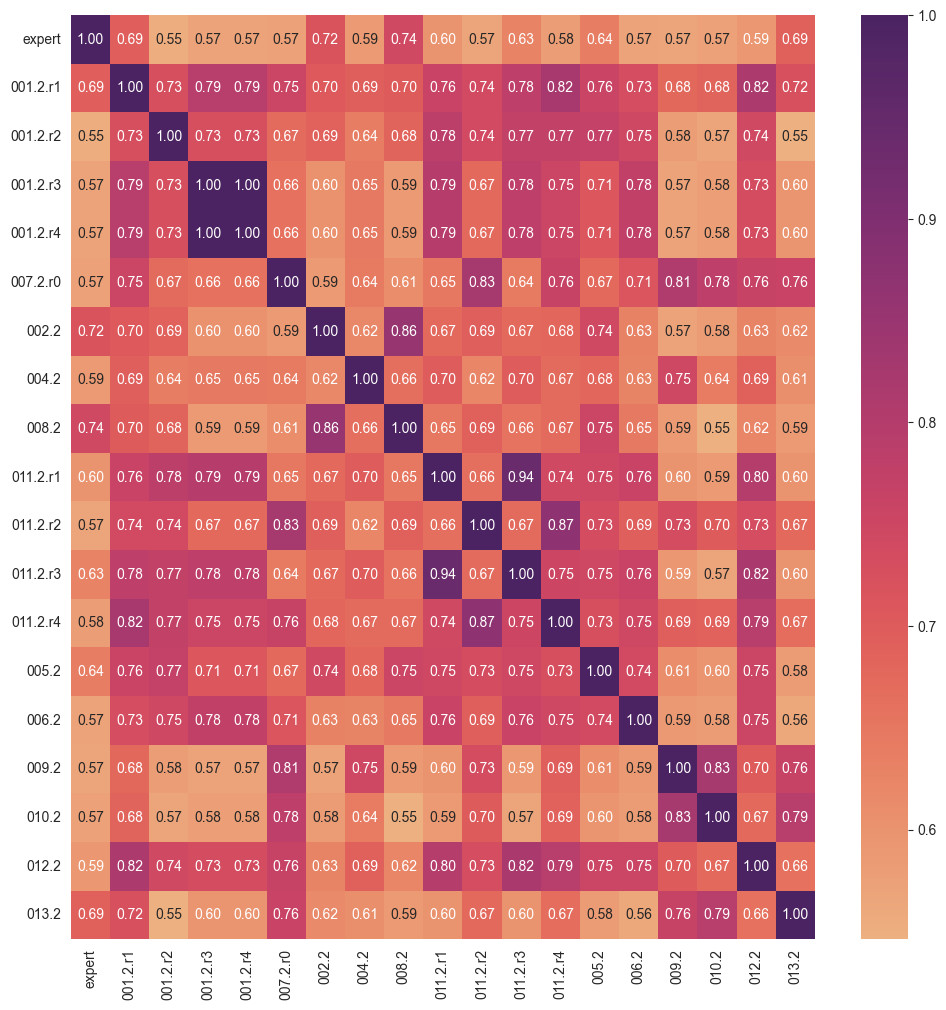

In [20]:
plt.figure(figsize=[12, 12])
sns.heatmap(rankings.corr(method='kendall'), annot=True, fmt=".2f", cmap='flare')
plt.show()

## Reordering (Exp. 011)

file='011.4_reorder1.log'
2025-02-21 21:15:32,233 [INFO] Sorting finished. Final order of notebooks: ['066e', 'fb4b', '9eb2', '6c5b', '8ac3', 'abd2', '63e1', 'ad47', '1953', '4ca2', '4c2a', '44bd', '21de', '6f62', '2281', 'fe28', '146f', '3669', '8d45', '88a6', 'b56b', 'c938', '7cc7', 'd28c', 'baa4', '6b4e', 'c926', 'a044', 'b14b', 'cb76', '8eaf', '8c43', 'eac9', '4c41', '23a6']

file='011.4_reorder2.log'
2025-02-21 21:27:45,589 [INFO] Sorting finished. Final order of notebooks: ['9eb2', 'fb4b', '066e', '6c5b', '8ac3', 'abd2', '4c2a', 'ad47', '63e1', '44bd', '21de', '1953', '4ca2', '2281', '3669', '6f62', 'b56b', '7cc7', 'fe28', '146f', 'c938', 'a044', 'b14b', '88a6', 'd28c', 'baa4', '6b4e', '8d45', '8c43', 'c926', 'cb76', '23a6', 'eac9', '8eaf', '4c41']

file='011.4_reorder3.log'
2025-02-21 22:37:12,257 [INFO] Sorting finished. Final order of notebooks: ['066e', 'fb4b', '9eb2', '6c5b', 'abd2', '8ac3', '63e1', '4c2a', 'ad47', '1953', '4ca2', '44bd', '21de', '3669', '2281', '6f62', 'fe2

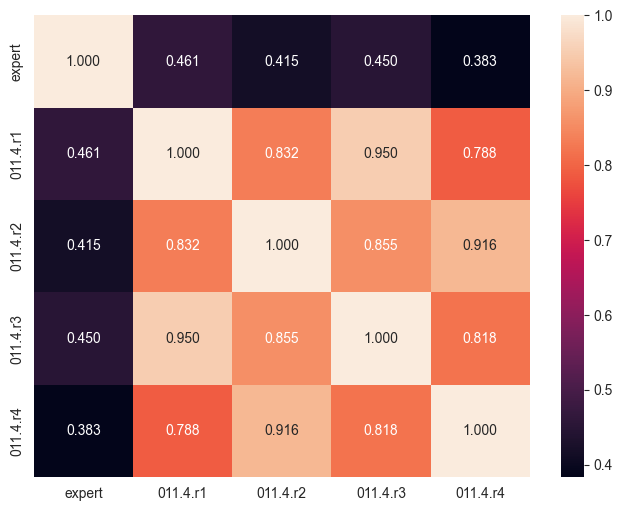

In [21]:
expert_ranking = pd.read_csv('data/shared-dataset-v2/werbeindustrie_points.csv')
rankings = expert_ranking.loc[:, ['id', 'total_points']]
rankings.rename(columns={'total_points': 'expert'}, inplace=True)

files = {
    '011.4.r1': '011.4_reorder1.log',
    '011.4.r2': '011.4_reorder2.log',
    '011.4.r3': '011.4_reorder3.log',
    '011.4.r4': '011.4_reorder4.log',
}

for experiment_id, file in files.items():
    with open(f'experiments/logs/{file}', 'r') as f:
        print(f'{file=}')
        for line in f.readlines():
            if re.match(r'.*Final order of notebooks:.*', line):
                print(line)
                matches = re.match(r'.*\[((\'[a-f0-9]+\'(, )?)+)\].*', line).group(1)
                ordering = [re.match(r"'([a-f0-9]+)'", m).group(1) for m in matches.split(', ')]

                rankings[experiment_id] = rankings['id'].map(lambda x: ordering.index(x))

rankings.set_index('id', inplace=True)
print(rankings.corr(method='kendall'))

plt.figure(figsize=[8, 6])
sns.heatmap(rankings.corr(method='kendall'), annot=True, fmt=".3f")
plt.show()

## Position Bias

In [22]:
comparisons = []
files = [
    '007.2_llama3.3_azure.log', '008.2_deepseek_azure.log', '009.2_markdown.log', '010.2_markdown_with_tags.log', '011.2_reorder1.log', '011.2_reorder2.log', '011.2_reorder3.log', '011.2_reorder4.log', '001.2_llama3.3_azure.1.log', '001.2_llama3.3_azure.2.log', '001.2_llama3.3_azure.3.log', '001.2_llama3.3_azure.4.log', '002.2_deepseek_azure.log', '004.2_azure_corona_warn_app.log', '005.2_markdown_with_tags.log', '006.2_majority_vote.log'
]

for file in files:
    with open(f'experiments/logs/{file}', 'r') as f:
        comparisons.extend([f.strip()[-11:] for f in f.readlines() if re.match(r'.*[a-f0-9]{4} [<>] [a-f0-9]{4}$', f)])

print(len(comparisons))

3167


In [23]:
def check_comparison(c: str) -> bool:
    a, cmp, b = c.split(' ')
    if cmp == '<':
        return expert_ranking.loc[expert_ranking['id'] == a, 'total_points'].values[0] <= expert_ranking.loc[expert_ranking['id'] == b, 'total_points'].values[0]
    else:
        return expert_ranking.loc[expert_ranking['id'] == a, 'total_points'].values[0] >= expert_ranking.loc[expert_ranking['id'] == b, 'total_points'].values[0]

def comparision_points_diff(c: str) -> int:
    a, cmp, b = c.split(' ')
    return expert_ranking.loc[expert_ranking['id'] == a, 'total_points'].values[0] - expert_ranking.loc[expert_ranking['id'] == b, 'total_points'].values[0]

problematic_notebooks: dict = {}
point_diffs: dict = {}

for c in comparisons:
    if check_comparison(c):
        print('Correct', end='')
        pass
    else:
        print('Wrong  ', end='')
        a, cmp, b = c.split(' ')
        problematic_notebooks[a] = problematic_notebooks.get(a, 0) + 1
        problematic_notebooks[b] = problematic_notebooks.get(b, 0) + 1

        point_diffs[a] = point_diffs.get(a, 0) - comparision_points_diff(c)
        point_diffs[b] = point_diffs.get(b, 0) + comparision_points_diff(c)

    print(f' {c} by {comparision_points_diff(c)}')

Wrong   146f < fe28 by 2
Wrong   fe28 > c926 by -5
Correct 8d45 < 8eaf by 0
Correct 8eaf < 88a6 by -5
Correct 6f62 > 6b4e by 2
Correct 6f62 < b14b by -4
Correct 23a6 > d28c by 2
Correct 23a6 > 21de by 5
Correct b56b > 6c5b by 6
Correct b56b > 4c2a by 1
Wrong   1953 < 2281 by 3
Correct 2281 > 066e by 5
Wrong   c938 > 8ac3 by -1
Wrong   c938 > 3669 by -3
Correct 9eb2 < eac9 by -10
Correct eac9 > 4c41 by 1
Correct cb76 > ad47 by 4
Wrong   cb76 > 63e1 by -1
Correct 88a6 > fe28 by 7
Correct 8d45 < 8eaf by 0
Wrong   8eaf > 8c43 by -3
Correct 23a6 > b14b by 1
Correct 21de < d28c by -3
Correct d28c > baa4 by 6
Wrong   2281 > b56b by -1
Correct 1953 > 066e by 8
Correct 1953 > abd2 by 4
Correct eac9 > c938 by 10
Correct 9eb2 < 4c41 by -9
Correct 4c41 > 44bd by 2
Correct 88a6 > cb76 by 5
Correct 8eaf > fe28 by 2
Correct 8d45 < 8c43 by -3
Correct 8c43 < 7cc7 by -2
Correct 8eaf < 7cc7 by -5
Correct 88a6 > 7cc7 by 0
Wrong   2281 > 23a6 by -5
Correct 1953 > b56b by 2
Wrong   abd2 < 066e by 4
Wrong   

In [24]:
for l in sorted(problematic_notebooks, key=lambda x: problematic_notebooks[x], reverse=True):
    print(f'{l}: {problematic_notebooks[l]}')

146f: 99
c938: 84
63e1: 84
b56b: 83
8c43: 82
fe28: 81
1953: 81
a044: 80
ad47: 79
3669: 78
baa4: 78
4ca2: 77
8ac3: 76
066e: 74
cb76: 68
6b4e: 66
2281: 62
8d45: 62
21de: 59
8eaf: 56
6f62: 54
44bd: 49
4c2a: 49
abd2: 45
23a6: 44
88a6: 44
c926: 41
eac9: 37
d28c: 33
4c41: 28
b14b: 25
6c5b: 20
9eb2: 19
7cc7: 18
fb4b: 15


In [25]:
# ↑ Zahl heißt das Notebook wird häufiger besser bewertet, als es eigentlich ist
# ↓ Zahl heißt das Notebook wird häufiger schlechter bewertet, als es eigentlich ist
print(f'Notb:   Score   Wrg.Comparisons   Total Points')
for l in sorted(point_diffs, key=lambda x: point_diffs[x], reverse=True):
    print(f'{l}:   {point_diffs[l]:5d}   {problematic_notebooks[l]:15d}   {expert_ranking.loc[expert_ranking["id"] == l, "total_points"].values[0]:10d}')

Notb:   Score   Wrg.Comparisons   Total Points
c938:     460                84            0
ad47:     403                79            0
baa4:     312                78            2
066e:     293                74            0
fe28:     284                81            2
2281:     222                62            5
3669:     192                78            3
8ac3:     170                76            1
cb76:      91                68            4
6c5b:      80                20            0
9eb2:      74                19            0
8eaf:      72                56            4
fb4b:      57                15            0
6b4e:      22                66            3
7cc7:      -7                18            9
d28c:     -20                33            8
63e1:     -24                84            5
4ca2:     -40                77            3
6f62:     -55                54            5
b14b:     -64                25            9
c926:     -66                41            7
4c2a:   

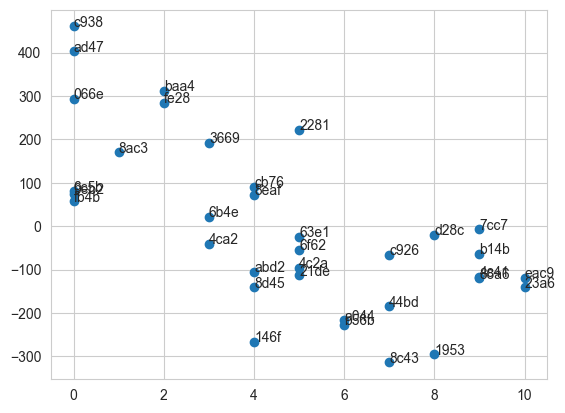

In [26]:
# plot score vs. total points
import matplotlib.pyplot as plt
import numpy as np

#x = [point_diffs[l] for l in point_diffs]
#y = [problematic_notebooks[l] for l in point_diffs]

x = [expert_ranking.loc[expert_ranking["id"] == l, "total_points"].values[0] for l in point_diffs]
y = [point_diffs[l] for l in point_diffs]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(point_diffs):
    ax.annotate(txt, (x[i], y[i]))

plt.show()

## Experiment 14: Position Bias

In [19]:
files = {
    '014.1': '014.1_position_bias.log',
    '014.2': '014.2_position_bias.log',
    '014.3': '014.3_position_bias.log',
    '014.4': '014.4_position_bias.log',
}

result_pairs: dict = {}
comparisons: dict = {}

for experiment_id, file in files.items():
    with open(f'experiments/logs/{file}', 'r') as f:
        print(f'{file=}')
        comparisons[experiment_id] = []
        for line in f.readlines():
            if re.match(r'.*Comparison results:.*', line):
                matches = re.match(r'.*(\[\(\(.*\)\]).*', line).group(1)
                pairs = eval(matches)
                result_pairs[experiment_id] = pairs
            if re.match(r'.*[a-f0-9]{4} [<>] [a-f0-9]{4}$', line):
                print(line.strip()[-11:])
                comparisons[experiment_id].append(line.strip()[-11:])

file='014.1_position_bias.log'
ad47 > 2281
2281 > ad47
4c41 > cb76
cb76 > 4c41
3669 < c938
c938 > 3669
066e > 9eb2
9eb2 < 066e
eac9 > c938
c938 > eac9
63e1 > b14b
b14b > 63e1
8ac3 < 146f
146f > 8ac3
8c43 > 88a6
88a6 > 8c43
fb4b < 6f62
6f62 > fb4b
baa4 > 2281
2281 > baa4
1953 > 6c5b
6c5b < 1953
4c41 > 066e
066e < 4c41
8c43 > 9eb2
9eb2 < 8c43
21de > 9eb2
9eb2 < 21de
ad47 < d28c
d28c > ad47
cb76 > 2281
2281 > cb76
1953 < 8eaf
8eaf > 1953
4ca2 < 6f62
6f62 > 4ca2
146f < fe28
fe28 > 146f
a044 > 6f62
6f62 < a044
88a6 > 6b4e
6b4e > 88a6
4c41 > 8d45
8d45 > 4c41
066e < 8d45
8d45 > 066e
3669 > 21de
21de < 3669
21de < d28c
d28c > 21de
fb4b < b14b
b14b > fb4b
8c43 > ad47
ad47 > 8c43
21de < cb76
cb76 > 21de
21de < 88a6
88a6 > 21de
baa4 > 6c5b
6c5b < baa4
88a6 > cb76
cb76 > 88a6
c938 > 6f62
6f62 < c938
4c41 > 6f62
6f62 < 4c41
63e1 > 4c2a
4c2a < 63e1
6c5b < 6b4e
6b4e > 6c5b
9eb2 < 8d45
8d45 > 9eb2
a044 > ad47
ad47 > a044
b14b > 1953
1953 > b14b
a044 < 1953
1953 > a044
abd2 < baa4
baa4 > abd2
7cc7 < ea

In [20]:
pos_bias: dict = {}
for k, v in comparisons.items():
    print(f'{k}: {len(v)}')
    pos_bias[k] = (0, 0)
    for i in range(0, len(v), 2):
        if v[i][5] != v[i + 1][5]:
            continue
        else:
            if v[i][5] == '>':
                pos_bias[k] = (pos_bias[k][0] + 1, pos_bias[k][1])
            elif v[i][5] == '<':
                pos_bias[k] = (pos_bias[k][0], pos_bias[k][1] + 1)
            else:
                print("Hää?")
print(pos_bias)

014.1: 1190
014.2: 1122
014.3: 992
014.4: 1056
{'014.1': (217, 0), '014.2': (98, 2), '014.3': (32, 8), '014.4': (53, 19)}


In [21]:
exp14_llama = pd.DataFrame({
    'Aufgabe': ['Corona-Pandemie', 'Corona-Warn-App', 'Reproduktionszahl', 'Werbeindustrie'],
    '$A > B$': [i[0] for i in pos_bias.values()],
    '$A < B$': [i[1] for i in pos_bias.values()],
    'Vergleiche': [len(v)//2 for v in comparisons.values()]
})

In [22]:
exp14_llama['$A > B$ [\\%]'] = exp14_llama['$A > B$'] / exp14_llama['Vergleiche']
exp14_llama['$A < B$ [\\%]'] = exp14_llama['$A < B$'] / exp14_llama['Vergleiche']

In [23]:
exp14_llama.set_index('Aufgabe')

,$A > B$,$A < B$,Vergleiche,$A > B$ [\%],$A < B$ [\%]
Aufgabe,,,,,
Corona-Pandemie,217,0,595,0.364706,0.000000
Corona-Warn-App,98,2,561,0.174688,0.003565
Reproduktionszahl,32,8,496,0.064516,0.016129
Werbeindustrie,53,19,528,0.100379,0.035985


In [24]:
#exp14_llama = pd.DataFrame({
#    'Aufgabe': ['Corona-Pandemie', 'Corona-Warn-App', 'Reproduktionszahl', 'Werbeindustrie'],
#    '$A > B$': [812, 657, 520, 562],
#    '$A < B$': [378, 465, 472, 494]
#})

In [18]:
sns.set_theme(style="whitegrid")

df = exp14_llama[['Aufgabe', '$A > B$', '$A < B$']].set_index('Aufgabe').stack()
df = df.reset_index()
df.columns = ['Aufgabe', 'LLM Bewertung', 'Anzahl Vergleiche']
sns.barplot(df, x='Aufgabe', y='Anzahl Vergleiche', hue='LLM Bewertung')
plt.show()

/tmp/ipykernel_106452/2684168528.py:7: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
  plt.show()


In [30]:
f, ax = plt.subplots(figsize=(6.5, 6.5/1.618))

df = exp14_llama[['Aufgabe', '$A > B$ [\\%]', '$A < B$ [\\%]']].set_index('Aufgabe').stack()
df = df.reset_index()
df.columns = ['Aufgabe', 'Vergleichsrichtung', 'Anteil aller Vergleiche je Aufgabe']

sns.barplot(df, x='Aufgabe', y='Anteil aller Vergleiche je Aufgabe', hue='Vergleichsrichtung', palette='deep')
plt.legend(title=r"Vergleichsergebnis bei\\Präsentationsreihenfolge $AB$")
plt.title(r'Anteil inkons. Vergleiche $C(AB) \neq C(BA)$ nach Position Bias Richtung (Llama 3.3)')
plt.ylabel(r'Anteil inkonsistenter Vergleiche [\%]')
plt.xlabel(r'')
plt.savefig('experiments/results/result2.3.pdf', dpi=300, bbox_inches='tight')

In [ ]:
# Damit A > B unten erscheint
#df = df.sort_values(by='Anzahl Vergleiche', ascending=True)

plt.figure(figsize=(7.0, 4.32))

#df['Anteil aller Vergleiche'] = df.groupby('Aufgabe')['Anzahl Vergleiche'].transform(lambda x: x / x.sum())

#normalize for each LLM Bewertung mit der Vergleiche spalte als summe
df['Anteil aller Vergleiche'] = df.groupby('Aufgabe')['Anzahl Vergleiche']


sns.histplot(df, x='Aufgabe', weights='Anteil aller Vergleiche', hue='LLM Bewertung', multiple='stack', shrink=0.8)
#sns.barplot(df, x='Aufgabe', y='Anteil aller Vergleiche', hue='LLM Bewertung')
plt.axhline(y=0.5, color='tab:red', linestyle='--')  # Linie bei 0.5

# change the font size of the x-axis labels
plt.xticks(fontsize=9)
plt.title("Anteil aller paarweisen Vergleiche mit Wahl der ersten / zweiten Option")
plt.ylabel(r'Anteil aller Vergleiche [\%]')
plt.xlabel("")

#sns.despine(trim=True, left=False)
plt.ylim(0, 1)
plt.savefig('experiments/results/result2.1.pdf', dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'Column not found: Anzahl Vergleiche'

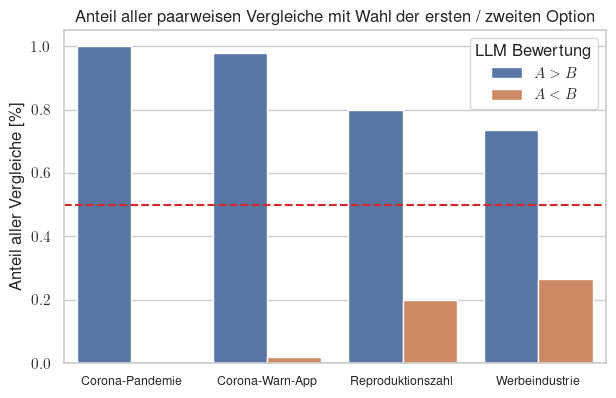

In [284]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]  # Setze Helvetica als Sans-Serif-Schrift
})

# Damit A > B unten erscheint
#df = df.sort_values(by='Anzahl Vergleiche', ascending=True)

# normalize for each LLM Bewertung
plt.figure(figsize=(7.0, 4.32))
df['Anteil aller Vergleiche'] = df.groupby('Aufgabe')['Anzahl Vergleiche'].transform(lambda x: x / x.sum())

#sns.histplot(df, x='Aufgabe', weights='Anteil aller Vergleiche', hue='LLM Bewertung', multiple='stack', shrink=0.8, hue_order=['$A < B$', '$A > B$'], palette=['C1', 'C0'])
sns.barplot(df, x='Aufgabe', y='Anteil aller Vergleiche', hue='LLM Bewertung')
plt.axhline(y=0.5, color='tab:red', linestyle='--')  # Linie bei 0.5

# change the font size of the x-axis labels
plt.xticks(fontsize=9)
plt.title("Anteil aller paarweisen Vergleiche mit Wahl der ersten / zweiten Option")
plt.ylabel(r'Anteil aller Vergleiche [\%]')
plt.xlabel("")

#sns.despine(trim=True, left=False)
plt.savefig('experiments/results/result2.2.pdf', dpi=300, bbox_inches='tight')
plt.show()

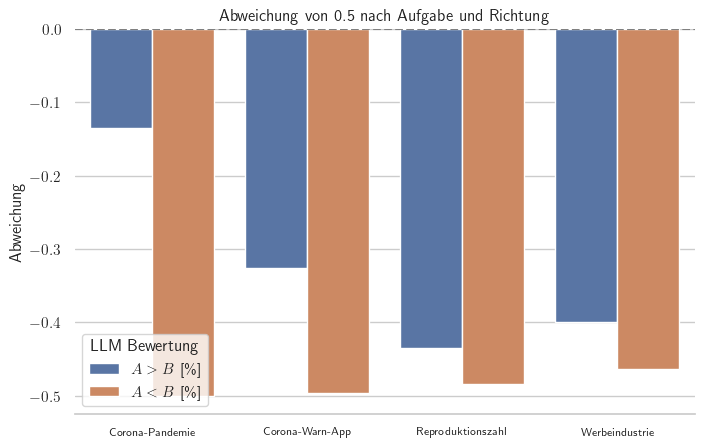

In [325]:
df = exp14_llama[['Aufgabe', '$A > B$ [\\%]', '$A < B$ [\\%]']].set_index('Aufgabe').stack()
df = df.reset_index()
df.columns = ['Aufgabe', 'LLM Bewertung', 'Anzahl Vergleiche']
df['Abweichung'] = df['Anzahl Vergleiche'] - 0.5

# Divergierendes Barplot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df,
    x='Aufgabe',
    y='Abweichung',  # Abweichung statt absoluter Werte
    hue='LLM Bewertung',
)
plt.axhline(0, color='gray', linestyle='--')  # Horizontale Linie bei 0 (entspricht 0.5)
plt.title("Abweichung von 0.5 nach Aufgabe und Richtung")
plt.xticks(fontsize=8)
plt.xlabel("")
sns.despine(trim=False, left=True)
plt.show()

## Experiment 014 mit DeepSeek

In [31]:
files = {
    '014.1': '014.1_position_bias.deepseek.log',
    '014.2': '014.2_position_bias.deepseek.log',
    '014.3': '014.3_position_bias.deepseek.log',
    '014.4': '014.4_position_bias.deepseek.log',
}

result_pairs: dict = {}
comparisons: dict = {}

for experiment_id, file in files.items():
    with open(f'experiments/logs/{file}', 'r') as f:
        print(f'{file=}')
        comparisons[experiment_id] = []
        for line in f.readlines():
            if re.match(r'.*Comparison results:.*', line):
                matches = re.match(r'.*(\[\(\(.*\)\]).*', line).group(1)
                pairs = eval(matches)
                result_pairs[experiment_id] = pairs
            if re.match(r'.*[a-f0-9]{4} [<>] [a-f0-9]{4}$', line):
                print(line.strip()[-11:])
                comparisons[experiment_id].append(line.strip()[-11:])

file='014.1_position_bias.deepseek.log'
b14b < 23a6
23a6 > b14b
b14b > ad47
ad47 > b14b
b14b > 63e1
63e1 > b14b
b14b > b56b
b56b > b14b
b14b > 44bd
44bd > b14b
b14b < baa4
baa4 > b14b
b14b > 066e
066e < b14b
b14b < fe28
fe28 > b14b
b14b > fb4b
fb4b < b14b
b14b < 2281
2281 > b14b
b14b > cb76
cb76 < b14b
b14b > 9eb2
9eb2 < b14b
b14b > 6c5b
6c5b < b14b
b14b < d28c
d28c > b14b
b14b < 8d45
8d45 > b14b
b14b < 8eaf
8eaf < b14b
b14b > 3669
3669 < b14b
b14b < 88a6
88a6 > b14b
b14b > 4ca2
4ca2 < b14b
b14b > 8ac3
8ac3 < b14b
b14b < 7cc7
7cc7 < b14b
b14b < 1953
1953 < b14b
b14b > 6b4e
6b4e > b14b
b14b > abd2
abd2 < b14b
b14b < a044
a044 > b14b
b14b > 4c2a
4c2a < b14b
b14b > c938
c938 > b14b
b14b > 8c43
8c43 < b14b
b14b < eac9
eac9 > b14b
b14b > 6f62
6f62 < b14b
b14b < 4c41
4c41 > b14b
b14b > 146f
146f < b14b
b14b < c926
c926 > b14b
b14b > 21de
21de < b14b
23a6 > ad47
ad47 < 23a6
23a6 > 63e1
63e1 < 23a6
23a6 > b56b
b56b < 23a6
23a6 > 44bd
44bd > 23a6
23a6 > baa4
baa4 > 23a6
23a6 > 066e
066e < 23a6


In [32]:
pos_bias: dict = {}
for k, v in comparisons.items():
    print(f'{k}: {len(v)}')
    pos_bias[k] = (0, 0)
    for i in range(0, len(v), 2):
        if v[i][5] != v[i + 1][5]:
            continue
        else:
            if v[i][5] == '>':
                pos_bias[k] = (pos_bias[k][0] + 1, pos_bias[k][1])
            elif v[i][5] == '<':
                pos_bias[k] = (pos_bias[k][0], pos_bias[k][1] + 1)
            else:
                print("Hää?")
print(pos_bias)

014.1: 1190
014.2: 1122
014.3: 992
014.4: 1056
{'014.1': (55, 27), '014.2': (29, 24), '014.3': (55, 15), '014.4': (44, 28)}


In [33]:
exp14_deepseek = pd.DataFrame({
    'Aufgabe': ['Corona-Pandemie', 'Corona-Warn-App', 'Reproduktionszahl', 'Werbeindustrie'],
    '$A > B$': [i[0] for i in pos_bias.values()],
    '$A < B$': [i[1] for i in pos_bias.values()],
    'Vergleiche': [len(v)//2 for v in comparisons.values()]
})

In [34]:
exp14_deepseek['$A > B$ [\\%]'] = exp14_deepseek['$A > B$'] / exp14_deepseek['Vergleiche']
exp14_deepseek['$A < B$ [\\%]'] = exp14_deepseek['$A < B$'] / exp14_deepseek['Vergleiche']

In [35]:
exp14_deepseek.set_index('Aufgabe')

,$A > B$,$A < B$,Vergleiche,$A > B$ [\%],$A < B$ [\%]
Aufgabe,,,,,
Corona-Pandemie,55,27,595,0.092437,0.045378
Corona-Warn-App,29,24,561,0.051693,0.042781
Reproduktionszahl,55,15,496,0.110887,0.030242
Werbeindustrie,44,28,528,0.083333,0.053030


In [31]:
sns.set_theme(style="whitegrid")

df = exp14_deepseek[['Aufgabe', '$A > B$', '$A < B$']].set_index('Aufgabe').stack()
df = df.reset_index()
df.columns = ['Aufgabe', 'LLM Bewertung', 'Anzahl Vergleiche']
sns.barplot(df, x='Aufgabe', y='Anzahl Vergleiche', hue='LLM Bewertung')
plt.show()

/tmp/ipykernel_106452/294991091.py:7: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
  plt.show()


In [36]:
f, ax = plt.subplots(figsize=(6.5, 6.5/1.618))

df = exp14_deepseek[['Aufgabe', '$A > B$ [\\%]', '$A < B$ [\\%]']].set_index('Aufgabe').stack()
df = df.reset_index()
df.columns = ['Aufgabe', 'Vergleichsrichtung', 'Anteil aller Vergleiche je Aufgabe']

sns.barplot(df, x='Aufgabe', y='Anteil aller Vergleiche je Aufgabe', hue='Vergleichsrichtung', palette='deep')
plt.legend(title=r"Vergleichsergebnis bei\\Präsentationsreihenfolge $AB$")
plt.title(r'Anteil inkons. Vergleiche $C(AB) \neq C(BA)$ nach Position Bias Richtung (DeepSeek-R1)')
plt.ylabel(r'Anteil inkonsistenter Vergleiche [\%]')
plt.xlabel(r'')
plt.savefig('experiments/results/result_exp14_deepseek.pdf', dpi=300, bbox_inches='tight')

In [40]:
# combine the two bar plots for exp14_llama and exp14_deepseek to one barplot showing the differences
plt.figure(figsize=(7.0, 4.32))

exp14_llama.rename(columns={'$A > B$ [\\%]': '$A > B$ [\\%] Llama', '$A < B$ [\\%]': '$A < B$ [\\%] Llama'}, inplace=True)
exp14_deepseek.rename(columns={'$A > B$ [\\%]': '$A > B$ [\\%] DeepSeek', '$A < B$ [\\%]': '$A < B$ [\\%] DeepSeek'}, inplace=True)
df = pd.merge(exp14_llama[['Aufgabe', '$A > B$ [\\%] Llama', '$A < B$ [\\%] Llama']], exp14_deepseek[['Aufgabe', '$A > B$ [\\%] DeepSeek', '$A < B$ [\\%] DeepSeek']], on='Aufgabe')
df = df.set_index('Aufgabe').stack()


df = df.reset_index()
df.columns = ['Aufgabe', 'Vergleichsrichtung', 'Anteil aller Vergleiche je Aufgabe']
sns.barplot(df, x='Aufgabe', y='Anteil aller Vergleiche je Aufgabe', hue='Vergleichsrichtung', palette='deep')
plt.legend(title=r"Vergleichsergebnis bei\\Präsentationsreihenfolge $AB$")
plt.title(r'Anteil inkonsistenter Vergleiche $C(AB) \neq C(BA)$ nach Position Bias Richtung (Llama 3.3 70B vs. DeepSeek-R1)')
plt.ylabel(r'Anteil inkonsistenter Vergleiche [\%]')
plt.xlabel(r'')
plt.savefig('experiments/results/result_exp14_combined.pdf', dpi=300, bbox_inches='tight')

In [43]:
df

,Aufgabe,Vergleichsrichtung,Anteil aller Vergleiche je Aufgabe
0,Corona-Pandemie,$A > B$ [\%] Llama,0.364706
1,Corona-Pandemie,$A < B$ [\%] Llama,-0.000000
2,Corona-Pandemie,$A < B$ [\%] Llama,0.092437
3,Corona-Pandemie,$A < B$ [\%] Llama,0.045378
4,Corona-Warn-App,$A > B$ [\%] Llama,0.174688
5,Corona-Warn-App,$A < B$ [\%] Llama,0.003565
6,Corona-Warn-App,$A < B$ [\%] Llama,0.051693
7,Corona-Warn-App,$A < B$ [\%] Llama,0.042781
8,Reproduktionszahl,$A > B$ [\%] Llama,0.064516
9,Reproduktionszahl,$A < B$ [\%] Llama,0.016129


## Inital Order Bias

In [2]:
import matplotlib as mpl
mpl.use('pdf')  # Verwende das pgf Backend

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    # Schriftgrößen – etwas kleiner als 12pt, damit die Figuren nicht „überladen“ wirken:
    "font.size": 10, # Allgemeine Schriftgröße (z. B. für Achsenbeschriftungen)
    "figure.titlesize": 11,
    "axes.titlesize": 10, # Titel der Achsen
    "axes.labelsize": 10, # Achsenbeschriftungen
    "legend.fontsize": 9, # Legenden Schriftgröße
    "xtick.labelsize": 9, # x-Achsen Tick-Beschriftung
    "ytick.labelsize": 9, # y-Achsen Tick-Beschriftung
    # Linienbreiten (falls feiner Strich gewünscht ist)
    "lines.linewidth": 1.0,

    "grid.color": 'gray',
    "grid.linestyle": '--',
    "grid.linewidth": 0.5,
    "axes.grid": True,  # Rasterlinien einfügen

    # Figurengröße – bei A4 und ggf. mehrspaltigem Layout sollte man sich an der für die jeweilige Spaltenbreite orientieren;
    # hier als Beispiel eine Breite von ca. 6.0 Zoll (15,2 cm) mit entsprechender Höhe:
    "figure.figsize": (6.5, 6.5/1.618),
    # Für gute Druckqualität:
    "savefig.dpi": 300,
    # Um den LaTeX-Praamble anzupassen, etwa um Helvetica (hier: helvet) für Überschriften zu laden,
    # kann man entsprechende Pakete einbinden.
    # \usepackage{helvet}
    #"text.latex.preamble": r"\renewcommand{\familydefault}{\sfdefault}"
    #r"\renewcommand{\familydefault}{\rmdefault}" # Setzt die Standardfamilie auf die LaTeX Standard Serifenschrift
    "pgf.rcfonts": True,  # Verwenden Sie nicht die Standard-Einstellungen von matplotlib
    "pgf.preamble": r"\usepackage[scaled=.95]{helvet}\renewcommand{\familydefault}{\sfdefault}",  # präambel wie benötigt
})

In [10]:
kendall_llama: dict = {
    'Corona-Pandemie':         [ 0.502201, 0.293805, 0.645687, 0.532948, 0.437291, 0.468038, 0.457789, 0.550030, 0.577360, 0.529532 ],
    'Corona-Warn-App':         [ 0.692684, 0.551680, 0.569306, 0.572831, 0.576356, 0.569306, 0.639808, 0.527004, 0.608082, 0.657433 ],
    'Reproduktionszahl':       [ 0.769186, 0.719788, 0.758600, 0.709203, 0.758600, 0.748015, 0.744487, 0.737430, 0.709203, 0.751544 ],
    'Werbeindustrie':          [ 0.407784, 0.425361, 0.404269, 0.404269, 0.432392, 0.421845, 0.418330, 0.348022, 0.404269, 0.428876 ]
}
# without outliers
kendall_llama_wo: dict = {
    'Corona-Pandemie':         [ 0.502201, pd.NA, 0.645687, 0.532948, 0.437291, 0.468038, 0.457789, 0.550030, 0.577360, 0.529532 ],
    'Corona-Warn-App':         [ 0.692684, 0.551680, 0.569306, 0.572831, 0.576356, 0.569306, 0.639808, 0.527004, 0.608082, 0.657433 ],
    'Reproduktionszahl':       [ 0.769186, 0.719788, 0.758600, 0.709203, 0.758600, 0.748015, 0.744487, 0.737430, 0.709203, 0.751544 ],
    'Werbeindustrie':          [ 0.407784, 0.425361, 0.404269, 0.404269, 0.432392, 0.421845, 0.418330, pd.NA, 0.404269, 0.428876 ]
}

In [5]:
# 8.0, 3.5
f, ax = plt.subplots(figsize=(6.5, 5./1.618))

# Whisker Länge ist 1.5 * Interquartilsabstand
sns.boxplot(kendall_llama, orient='h', width=.6, fliersize=1, palette="tab10", ax=ax)
sns.stripplot(kendall_llama, orient='h', size=4, color=".1", alpha=.7, marker='X', ax=ax)

plt.title(r'Intrarater-Reliabilität (Llama 3.3 70B) unter Variation der Anfangssortierung')
plt.tight_layout()

ax.set_xlim(0.28, 0.78)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))

ax.xaxis.grid(True, which='major')
#ax.xaxis.grid(True, which='minor', linestyle=':', linewidth='0.4', color='gray')


ax.set(xlabel=r'Rangkorrelation mit Experten-Ranking [Kendalls $\tau$]', ylabel='')

plt.subplots_adjust(top=0.9)

#sns.despine(trim=False, left=True)
plt.savefig('experiments/results/result1.pdf', dpi=300, bbox_inches='tight')

In [12]:
pd.DataFrame(kendall_llama_wo).mean(skipna=True).round(4)

Corona-Pandemie       0.52232
Corona-Warn-App      0.596449
Reproduktionszahl    0.740606
Werbeindustrie       0.416377
dtype: object

### DeepSeek

In [21]:
kendall_deepseek: dict = {
    'Corona-Pandemie':      [ 0.621773, 0.618356, 0.591026, 0.666185, 0.638854, 0.666185, 0.679850, 0.679850, 0.669601, 0.601275, 0.591026, 0.642271 ],
    'Corona-Warn-App':      [ 0.717360, 0.742036, 0.766712, 0.720885, 0.703260, 0.660958, 0.738511, 0.734986, 0.685634, 0.71031, 0.720885, 0.731461 ],
    'Reproduktionszahl':    [ 0.635107, 0.635107, 0.691561, 0.656278, 0.702146, 0.666863, 0.691561, 0.684505, 0.624522, 0.617465, 0.624522, 0.652749 ],
    'Werbeindustrie':       [ 0.492153, 0.485122, 0.474576, 0.523791, 0.485122, 0.488638, 0.488638, 0.478091, 0.520276, 0.481607, 0.506214, 0.464030 ]
}

In [ ]:
f, ax = plt.subplots(figsize=(6.5, 6.5/1.618))

# Whisker Länge ist 1.5 * Interquartilsabstand
sns.boxplot(kendall_deepseek, orient='h', width=.5, fliersize=0, palette="deep", ax=ax)
sns.stripplot(kendall_deepseek, orient='h', size=4, color=".3", ax=ax)

plt.title(r'Interrater-Reliabilität unter Variation der Anfangssortierung (DeepSeek-R1)')
plt.tight_layout()

ax.set_xlim(0.45, 0.77)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))

ax.xaxis.grid(True, which='major')
#ax.xaxis.grid(True, which='minor', linestyle=':', linewidth='0.4', color='gray')


ax.set(xlabel=r'Rangkorrelation mit Experten-Ranking [Kendalls $\tau$]', ylabel='')

plt.subplots_adjust(top=0.9)

#sns.despine(trim=False, left=True)
plt.savefig('experiments/results/result1.deepseek.pdf', dpi=300, bbox_inches='tight')

In [102]:
data = []
for key in kendall_llama:
    for value in kendall_llama[key]:
        data.append({'Category': key, 'Value': value, 'LLM': 'Llama 3.3 70B'})
    for value in kendall_deepseek[key]:
        data.append({'Category': key, 'Value': value, 'LLM': 'DeepSeek-R1'})

df = pd.DataFrame(data)

fig, axes = plt.subplots(4, 1, figsize=(6, 5), sharex=True)

categories = ['Corona-Pandemie', 'Corona-Warn-App', 'Reproduktionszahl', 'Werbeindustrie']

palette = sns.color_palette("tab20", 12)

hue_counter: int = 0
for ax, category in zip(axes, categories):
    hue_colors = palette[hue_counter:hue_counter+2]
    sns.boxplot(x='Value', y='LLM', data=df[df['Category'] == category], hue='LLM', ax=ax, width=.6, fliersize=0, palette=hue_colors, linecolor="black")
    #sns.stripplot(x='Value', y='LLM', data=df[df['Category'] == category], hue='LLM', ax=ax, size=4, jitter=True, palette=hue_colors, edgecolor="black", marker='X', linewidth=.4)
    sns.stripplot(x='Value', y='LLM', data=df[df['Category'] == category], ax=ax, jitter=True, size=4, color=".1", alpha=.7, marker='X')
    ax.set_title(category)
    ax.set_xlabel(r'Rangkorrelation mit Experten-Ranking [Kendalls $\tau$]')
    ax.set_ylabel('')

    ax.set_xlim(0.38, 0.78)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))

    hue_counter += 2


plt.suptitle('Interrater-Reliabilität unter Variation der Anfangssortierung\nLlama 3.3 70B Instruct vs. DeepSeek-R1')
#plt.xlabel(r'Rangkorrelation mit Experten-Ranking [Kendalls $\tau$]')

#sns.despine(trim=False, left=True)
plt.tight_layout()
plt.savefig('experiments/results/result1.llama-deepseek.pdf', dpi=300, bbox_inches='tight')

In [ ]:
print("TEst")

In [36]:
[*[0]*11, *[1]*11]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]